## 03. Computer Vision with PyTorch

What we're going to cover:
* Basic dataset
    * PyTorch FashionMNIST - https://pytorch.org/vision/stable/datasets.html
* Custom dataset 
    * (made from scratch)
* Visualizing models

Workflow:

1. Data (prepare and load)
2. Build model
3. Fitting model to data (training)
4. Making predictions and evaluating a model (inference)
    * Improving a model through experimentations (optional)
5. Saving and loading model
6. Putting it all together

In [1]:
import torch
from torch import nn

## Data

In [37]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [38]:
# Check out the data shapes
img, label = train_data[0]
img.shape, label # image is [1, 28, 28] and has int label

(torch.Size([1, 28, 28]), 9)

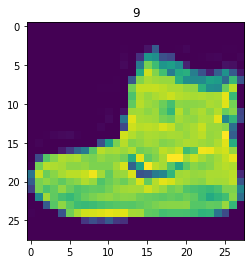

In [39]:
import matplotlib.pyplot as plt
img, label = train_data[0]
plt.imshow(img.squeeze()) # image shape is [1, 28, 28] (batch, height, width)
plt.title(label);

In [10]:
# Map labels to class names - https://github.com/zalandoresearch/fashion-mnist
# List format - https://gist.github.com/mrdbourke/e0b82c52a1b374a108a47ce21c7f4835
class_names = ["T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

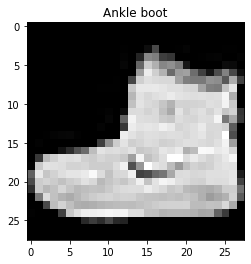

In [40]:
img, label = train_data[0]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label]);

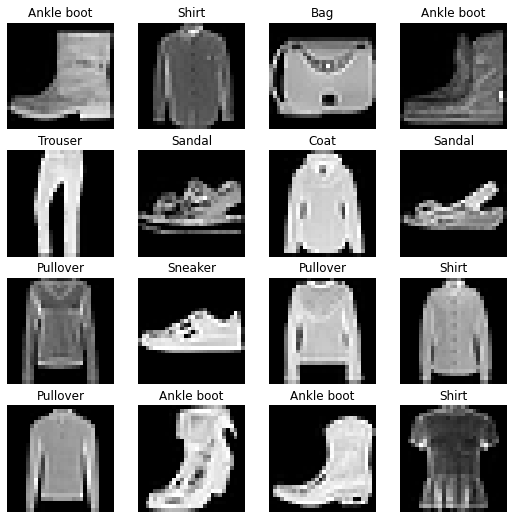

In [41]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

TK - Can these be modelled with straight lines? Let's try.

## TK - Prepare DataLoader

In [51]:
from torch.utils.data import DataLoader

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=32, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=32,
    shuffle=True
)

train_dataloader, test_dataloader, len(train_dataloader), len(test_dataloader)

(<torch.utils.data.dataloader.DataLoader at 0x7f4f51fd8c70>,
 1875,
 313)

In [46]:
# Check out dataloader
# TK - If using VSCode, be sure to check these out in the Data Viewer (go to Variables -> pick the variable you want to inspect)
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 7, label size: torch.Size([])


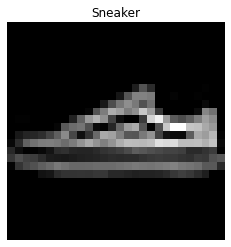

In [58]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## TK - Build a model

Now our features and labels are prepared, let's build a model.

In [71]:
flatten_model = nn.Sequential(nn.Flatten())
x = train_features_batch[0]
output = flatten_model(x)
x.shape, output.size()


(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [72]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # TK - explain in and out features (could use TF playground for this)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [74]:
# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=512, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [75]:
# Setup loss and optimizer 
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion" in some places
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [76]:
# TK - import accuracy function 

In [81]:
# Create training loop
epochs = 100
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}\n-------------")
    for batch, (X, y) in enumerate(train_dataloader):
        # Training
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out what's happening
        if batch % 100 == 0:
            batch_number = batch * len(X)
            print(f"Loss: {loss:.5f} | Samples: {batch_number}/{len(train_dataloader.dataset)}")
    
    # TODO: Go through testing...


Epoch 1
-------------
Loss: 0.41407 | Samples: 0/60000
Loss: 0.43900 | Samples: 3200/60000
Loss: 0.51927 | Samples: 6400/60000
Loss: 0.27118 | Samples: 9600/60000
Loss: 0.17200 | Samples: 12800/60000
Loss: 0.16509 | Samples: 16000/60000
Loss: 0.59558 | Samples: 19200/60000
Loss: 0.39876 | Samples: 22400/60000
Loss: 0.49365 | Samples: 25600/60000
Loss: 0.72456 | Samples: 28800/60000
Loss: 0.23277 | Samples: 32000/60000
Loss: 0.54337 | Samples: 35200/60000
Loss: 0.65953 | Samples: 38400/60000
Loss: 0.35185 | Samples: 41600/60000
Loss: 0.35520 | Samples: 44800/60000
Loss: 0.47678 | Samples: 48000/60000
Loss: 0.32234 | Samples: 51200/60000
Loss: 0.25257 | Samples: 54400/60000
Loss: 0.28981 | Samples: 57600/60000

Epoch 2
-------------
Loss: 0.71554 | Samples: 0/60000
Loss: 0.54448 | Samples: 3200/60000
Loss: 0.55865 | Samples: 6400/60000
Loss: 0.36308 | Samples: 9600/60000
Loss: 0.61155 | Samples: 12800/60000
Loss: 0.38506 | Samples: 16000/60000
Loss: 0.23072 | Samples: 19200/60000
Loss: 

KeyboardInterrupt: 

# TODO:
* make testing code for training loop above
* bring in accuracy function to measure accuracy function
* TK - "We're writing a lot of boiler plate code... but that's to practice"
* bring in non-linearity for model 1 (it works on FashionMNIST)
* then bring in another dataset (custom dataset)
* try model_1 on custom dataset (does it work?)
* try TinyVGG on custom dataset (conv layers etc) - https://poloclub.github.io/cnn-explainer/